In [1]:
from multi_nutrient_model import ref_parameters,  I0, sensitivity_analysis, PARAMETER_NAMES, PARAMETER_DESCRIPTIONS
from multi_nutrient_model import perturbation_dynamics, perturbation_steady_state, TAU_INS
import numpy as np

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# TODO Better colors for this figure

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['grey', 'indianred'] 



In [3]:
# Scaling 

# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2000 * 0.7 
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 


In [4]:
KI_F = 0.2
p_fited = ref_parameters( KI_F = KI_F)

In [5]:
# Map to parameter symbols in the paper
PARAMETER_SYMBOLS = {"vE" : r"v_E",
                     "Imax": r"I_{max}",
                     "C": r'C',
                     "k": r'h',
                     "omega" : r"k_{glcyolysis}",
                     "lam": r"k_{lactate}",
                     "gamma": r"k_{glucose}",
                     "beta": r"k_{fatty acids}",
                     "kappa": r"k_{3HB}",
                     "alpha": r"k_{lipolysis}",
                    'VR': r'k_{reesterification}',
                    'VFK': r'k_{ketogenesis}' ,
                    'VLG': r'k_{GNG,lactate}',
                    'v0': r'V_{glycogenolysis}',
                    'KI_lipo': r'K_{i,lipolysis}',
                    "KA_glut4": r"K_{a,glycolysis}",
                    "KI_GL": r"K_{i,glycogenolysis}",
                    "KI_F": r"K_{i,ketogenesis}"
                    }

In [6]:
# compute sensitivity indices 

SENS_PARAMS = ["vE", "Imax", 'C' , "omega", "lam", "gamma", "beta","k",
                "kappa", "alpha", "VR", "VFK", "VLG", "v0",  "KI_lipo", "KA_glut4", "KI_GL","KI_F"]


results_healthy = dict()
results_obese = dict()
for p in SENS_PARAMS:
    S_0 = sensitivity_analysis(p,1.0, p=p_fited,fold_change=None,)
    results_healthy[p] = S_0
    results_obese[p] = sensitivity_analysis(p,3.0, p=p_fited, fold_change=None,)


df_healthy = pd.DataFrame(results_healthy).T
df_obese = pd.DataFrame(results_obese).T

# Drop the last colums - they fluxes that are 0 by definition
df_healthy = df_healthy.drop(columns=["v_in_L","v_in_G","v_in_F","v_in_K","vI"], axis=1)
df_obese = df_obese.drop(columns=["v_in_L","v_in_G","v_in_F","v_in_K","vI"], axis=1)

# Add a condition column
df_healthy["Condition"] = "Healthy"
df_obese["Condition"] = "Obese"

# Combine the two dataframes
# df = pd.concat([df_healthy, df_obese])
df = df_obese

df.reset_index(inplace=True)
df = df.rename(columns={"index": "Parameter"})

# Map the parameter names to the descriptions
df["ParameterDescription"] = df["Parameter"].map(PARAMETER_SYMBOLS)
# Add $ signs around the descriptions for latex rendering
df["ParameterDescription"] = df["ParameterDescription"].apply(lambda x: f"${x}$")
# Get numierical columns
num_col = df.select_dtypes(include=[np.number]).columns



In [7]:
order = df.groupby("ParameterDescription")["HOMA_IR"].mean().abs().sort_values(ascending=False).index
order

Index(['$v_E$', '$k_{lipolysis}$', '$k_{reesterification}$',
       '$K_{i,lipolysis}$', '$V_{glycogenolysis}$', '$k_{fatty acids}$', '$C$',
       '$k_{glcyolysis}$', '$h$', '$k_{GNG,lactate}$', '$k_{lactate}$',
       '$K_{i,glycogenolysis}$', '$k_{glucose}$', '$I_{max}$',
       '$K_{a,glycolysis}$', '$k_{ketogenesis}$', '$K_{i,ketogenesis}$',
       '$k_{3HB}$'],
      dtype='object', name='ParameterDescription')

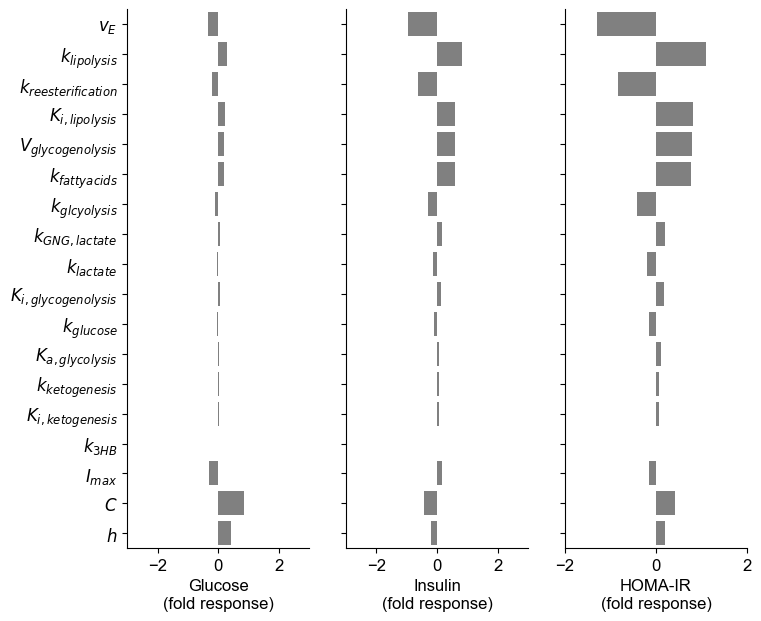

In [8]:
# Make a bar graph of the glucose sensitivity indices
fig, ax = plt.subplots(1, 3, figsize=(8, 7), sharey=True, )

# Order by the glucose sensitivity
# Get obese only data
order = df[df["Condition"] == "Obese"].groupby("ParameterDescription")["HOMA_IR"].mean()\
            .abs().sort_values(ascending=False).index

# Group insulin sensitivty parameter Imax C and h togher at the end
# Move Imax, C, h to the end of the order
order = [x for x in order if x not in [r"$I_{max}$", r'$C$', r'$h$']] + [r"$I_{max}$", r'$C$', r'$h$']

# Define colors for positive and negative effects using hex codes
positive_color = "#E3862A"  # Coral orange
negative_color = "#4682B4"  # Steel blue

def get_bar_colors(values):
    return [positive_color if x > 0 else negative_color for x in values]

# Glucose sensitivity
glucose_values = df.set_index("ParameterDescription").loc[order, "G"]
glucose_colors = get_bar_colors(glucose_values)
sns.barplot(data=df, y="ParameterDescription" ,x='G', ax=ax[0], order=order, hue="Condition",
            #palette=homa_colors
            palette=['grey','firebrick'],
            legend=False
            )
ax[0].set_xlim(-3, 3)
ax[0].set_xlabel("Glucose\n(fold response)")
ax[0].set_ylabel("")

# Insulin sensitivity
insulin_values = df.set_index("ParameterDescription").loc[order, "I"]
insulin_colors = get_bar_colors(insulin_values)
sns.barplot(data=df, y="ParameterDescription" ,x='I', ax=ax[1],order=order, hue="Condition",
            #palette=homa_colors
            palette=['grey','firebrick'],
            legend=False
            )
ax[1].set_xlim(-3, 3.0)
ax[1].set_xlabel("Insulin\n(fold response)")
ax[1].set_ylabel("")

# HOMA-IR sensitivity
homa_values = df.set_index("ParameterDescription").loc[order, "HOMA_IR"]
homa_colors = get_bar_colors(homa_values)
sns.barplot(data=df, y="ParameterDescription" ,x='HOMA_IR', ax=ax[2], order=order, hue="Condition",
            #palette=homa_colors
            palette=['grey','firebrick'],
            legend=False
            )
ax[2].set_xlim(-2, 2.0)
ax[2].set_xlabel("HOMA-IR\n(fold response)")
ax[2].set_ylabel("")

# # Create legend for color coding
# from matplotlib.patches import Rectangle
# colors = ['grey','firebrick']
# legend_elements = [Rectangle((0,0),1,1, facecolor=colors[0], label='Lean'),
#                    Rectangle((0,0),1,1, facecolor=colors[1], label='Obese')]
# fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, frameon=False)


sns.despine()

# Save the figure
plt.savefig("output/sensitivity_glucose_insulin_homa_ir.svg", bbox_inches='tight')

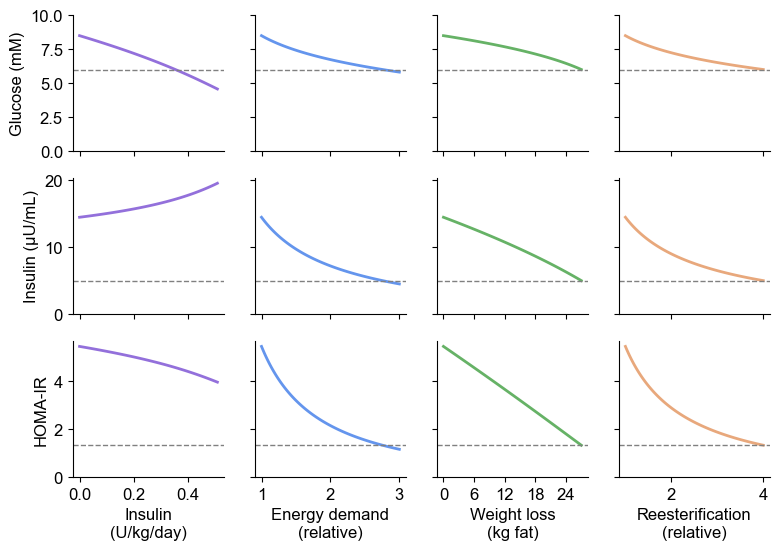

In [9]:
#
fig, ax = plt.subplots(3, 4, figsize=(9, 6), sharey='row', sharex='col')

# Scale the X to units of mM
X_base = {'F':0.5, 'G':6.0, 'I': 5.0/I0}

# 1. Vary C parameter (first column)
I_dose = I0/TAU_INS
C = np.linspace(0, 3.5, 100) * I0/TAU_INS
X = [perturbation_steady_state(3.0, p=p_fited, v_in_I=c) for c in C]
X = pd.DataFrame(X, columns=["L","G","F","K","I","IA"])
X["G"] = X["G"] * X_base["G"]
X["I"] = X["I"] * X_base["I"]
X["HOMA_IR"] = X["G"] * X["I"] / 22.5  # Calculate HOMA-IR
# Inuslin secretion per glucose -> I/C
# I dose 1.25 mU/min/kg
 # 0.081 mouse to human scaling factor (
# Scale to daily dose 
scaling = 1.25 / 1000 * 60 * 24 * 0.081
sns.lineplot(data=X, x=C/I_dose*scaling, y="G", ax=ax[0,0], color='#9370DB', linewidth=2)
sns.lineplot(data=X, x=C/I_dose*scaling, y="I", ax=ax[1,0], color='#9370DB', linewidth=2)
sns.lineplot(data=X, x=C/I_dose*scaling, y="HOMA_IR", ax=ax[2,0], color='#9370DB', linewidth=2)


# # 2. Vary glycogenolysis (second column)
# v0_ix = PARAMETER_NAMES.index("v0")
# v0 = np.linspace(1/3, 1, 100) * p_fited[v0_ix]
# X = [perturbation_steady_state(3.0, p=p_fited, v0=v) for v in v0]
# X = pd.DataFrame(X, columns=["L","G","F","K","I","IA"])
# X["G"] = X["G"] * X_base["G"]
# X["I"] = X["I"] * X_base["I"]
# X["HOMA_IR"] = X["G"] * X["I"] / 22.5
# sns.lineplot(data=X, x=v0/p_fited[v0_ix], y="G", ax=ax[0,1], color='k')
# sns.lineplot(data=X, x=v0/p_fited[v0_ix], y="I", ax=ax[1,1], color='k')
# sns.lineplot(data=X, x=v0/p_fited[v0_ix], y="HOMA_IR", ax=ax[2,1], color='k')

# 3. Vary energy expenditure (third column)
vE_values = np.linspace(1, 3, 100)
X = [perturbation_steady_state(3.0, p=p_fited, vE=vE) for vE in vE_values]
X = pd.DataFrame(X, columns=["L","G","F","K","I","IA"])
X["G"] = X["G"] * X_base["G"]
X["I"] = X["I"] * X_base["I"]
X["HOMA_IR"] = X["G"] * X["I"] / 22.5
sns.lineplot(data=X, x=vE_values, y="G", ax=ax[0,1], color='#6495ED', linewidth=2)
sns.lineplot(data=X, x=vE_values, y="I", ax=ax[1,1], color='#6495ED', linewidth=2)
sns.lineplot(data=X, x=vE_values, y="HOMA_IR", ax=ax[2,1], color='#6495ED', linewidth=2)

# 4. Vary lipolytic propensity (fourth column)
alpha_ix = PARAMETER_NAMES.index("alpha")
# Compute A for 3
alpha = np.linspace(3, 1, 100)

X = [perturbation_steady_state(a, p=p_fited) for a in alpha]
X = pd.DataFrame(X, columns=["L","G","F","K","I","IA"])

X["G"] = X["G"] * X_base["G"]
X["I"] = X["I"] * X_base["I"]
X["HOMA_IR"] = X["G"] * X["I"] / 22.5

# Conver alpha to absolute weight loss 
# Normal fat mass 18% of 75 kg is 13.5 kg
# 3 time fat mass is then 40.5 kg / (75 + 40.5) = 0.35 -> 35%

fm_delta = (3 - alpha) * 13.5# kg fat mass lost

sns.lineplot(data=X, x=fm_delta, y="G", ax=ax[0,2], color='#66B266', linewidth=2)
sns.lineplot(data=X, x=fm_delta, y="I", ax=ax[1,2], color='#66B266', linewidth=2)
sns.lineplot(data=X, x=fm_delta, y="HOMA_IR", ax=ax[2,2], color='#66B266', linewidth=2)


# 5. Vary reesterification (fifth column)
VR_ix = PARAMETER_NAMES.index("VR")
VR = np.linspace(1, 4, 100) * p_fited[VR_ix]
X = [perturbation_steady_state(3.0, p=p_fited, VR=v) for v in VR]
X = pd.DataFrame(X, columns=["L","G","F","K","I","IA"])
X["G"] = X["G"] * X_base["G"]
X["I"] = X["I"] * X_base["I"]
X["HOMA_IR"] = X["G"] * X["I"] / 22.5
sns.lineplot(data=X, x=VR/p_fited[VR_ix], y="G", ax=ax[0,3], color='#E8A87C', linewidth=2)
sns.lineplot(data=X, x=VR/p_fited[VR_ix], y="I", ax=ax[1,3], color='#E8A87C', linewidth=2)
sns.lineplot(data=X, x=VR/p_fited[VR_ix], y="HOMA_IR", ax=ax[2,3], color='#E8A87C', linewidth=2)

# Set y labels
ax[0,0].set_ylabel("Glucose (mM)")
ax[1,0].set_ylabel("Insulin (μU/mL)")
ax[2,0].set_ylabel("HOMA-IR")

# Change lower limit of y axis to 0 
for a in ax.flatten():
    a.set_ylim(bottom=0)

# # Set x axis to log 
# for a in ax.flatten():
#     a.set_xscale("log", base=2)

# Set x labels and ticks
ax[2,0].set_xlabel("Insulin\n(U/kg/day)")
#ax[2,1].set_xlabel("Glycogenolysis\n(relative)")
ax[2,1].set_xlabel("Energy demand\n(relative)")
ax[2,2].set_xlabel("Weight loss\n(kg fat)")
ax[2,3].set_xlabel("Reesterification\n(relative)")

# # Insulin 
# ax[2,1].invert_xaxis()
# ax[2,1].set_xticks([1, 2/3, 1/3])
# ax[2,1].set_xticklabels(["1", "2/3", "1/3"])

# Weight loss
ax[2,2].set_xticks([0, 6, 12, 18, 24])

# Set glucose y limit
ax[0,0].set_ylim(0, 10)

for i in range(4):
    # Add horizontal lines for healthy glucose and insulin levels
    ax[0,i].axhline(6.0, color='grey', linestyle='--', linewidth=1)
    ax[1,i].axhline(5.0, color='grey', linestyle='--', linewidth=1)
    ax[2,i].axhline(6 * 5/22.5, color='grey', linestyle='--', linewidth=1)

sns.despine()

# Save the figure
plt.savefig("output/sensitivity_perturbations.svg", bbox_inches='tight')